# `cloudwatcher` Python API usage

The purpose of this page is to provide a quick overview of the `cloudwatcher` Python API. The package consists of two user-facing classes:

- `MetricWatcher`: This class is used to interact with AWS CloudWatch metrics.
- `LogWatcher`: This class is used to interact with AWS CloudWatch logs.

Both of these classes inherit from the `CloudWatcher` class.

## `MetricWatcher`: convenient interface to AWS CloudWatch metrics

`MetricWatcher` can be used to interact with AWS CloudWatch metrics. 

### `MetricWatcher` initialization

As described in the Login credentials section, the AWS credentials can be sourced from environment variables: `AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY`, `AWS_SESSION_TOKEN`.
Alternatively, you can pass the values as arguments to the `MetricWatcher` constructor.

In [1]:
from cloudwatcher.metricwatcher import MetricWatcher
from cloudwatcher.preset import Dimension
from dotenv import load_dotenv
import os

load_dotenv()

instance_id = os.environ.get("INSTANCE_ID")
mw = MetricWatcher(
    namespace="NepheleNamespaceEC2",
    metric_name="mem_used",
    metric_id="mem_used",
    metric_unit="Bytes",
    dimensions_list=[Dimension(Name="InstanceId", Value=instance_id)],
)

### `MetricWatcher` presets

As you can see there are multiple arguments that can be passed to `MetricWatcher` constructor. In order to improve the UX when using `MetricWatcher` `cloudwatcher` package provides a few presets that can be used to query the data reported by `CloudWatchAgent` within certain systems. Additionally, custom presets can be defined by the user and used in the same way.

Presets are JSON-formatted files that provide parameter bundles for `MetricWatcher` initialization.

#### Usage

Listing available presets:


In [2]:
from cloudwatcher.preset import PresetFilesInventory
from rich.console import Console

pfi = PresetFilesInventory()
Console().print(pfi.presets_table)

                 Presets available in: /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name                                   ┃ Path                                                                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ nephele_disk_used_percent              │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_di… │
│ nephele_mem_cached                     │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_me… │
│ nephele_mem                            │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_me… │
│ nephele_disk_used_percent_nephele_data │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_di… │
│ nephele_cpu_usage_user                 │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_cp… │
│ nephele_processes_dead                 │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_pr… │
│ nephele_swap_used_percent              │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_sw… │
│ nephele_swap_used                      │ /Users/stolarczykmj/code/cloudwatcher/cloudwatcher/presets/nephele_sw… │
└────────────────────────────────────────┴────────────────────────────────────────────────────────────────────────┘

Using a preset:

In [3]:
from cloudwatcher.preset import MetricWatcherSetup
mw_setup = MetricWatcherSetup.from_json(pfi.get_preset_path("nephele_mem"))
mw_setup.upsert_dimensions([f"InstanceId:{instance_id}"])
mw = MetricWatcher(**mw_setup.to_dict())
query_kwargs = {
    "days": 5,
    "hours": 0,
    "minutes": 0,
    "stat": "Maximum",
    "period": 60,
}
response = mw.query_ec2_metrics(**query_kwargs)
print(response)


{'MetricDataResults': [{'Id': 'nephele', 'Label': 'mem_used', 'Timestamps': [datetime.datetime(2023, 7, 19, 16, 45, tzinfo=tzutc()), datetime.datetime(2023, 7, 19, 16, 44, tzinfo=tzutc()), datetime.datetime(2023, 7, 19, 16, 43, tzinfo=tzutc()), datetime.datetime(2023, 7, 19, 16, 42, tzinfo=tzutc()), datetime.datetime(2023, 7, 19, 16, 41, tzinfo=tzutc()), datetime.datetime(2023, 7, 19, 16, 40, tzinfo=tzutc()), datetime.datetime(2023, 7, 19, 16, 39, tzinfo=tzutc()), datetime.datetime(2023, 7, 19, 16, 38, tzinfo=tzutc()), datetime.datetime(2023, 7, 19, 16, 37, tzinfo=tzutc()), datetime.datetime(2023, 7, 19, 16, 36, tzinfo=tzutc()), datetime.datetime(2023, 7, 19, 16, 35, tzinfo=tzutc()), datetime.datetime(2023, 7, 19, 16, 34, tzinfo=tzutc())], 'Values': [486064128.0, 485814272.0, 4685066240.0, 6207594496.0, 4992217088.0, 4720185344.0, 2435854336.0, 2444738560.0, 2400739328.0, 11007488000.0, 2191474688.0, 576376832.0], 'StatusCode': 'Complete'}], 'Messages': [], 'ResponseMetadata': {'Reques




### Querying AWS CloudWatch metrics

In order to specify the EC2 instace query settings (period, granularity, etc.), the user would need to provide multiple parameters. To make it easier, there are a few sensible presets that can be used to select the query settings, which are passed to `query_ec2_metrics` method. These presets are defined to query the data reported by `CloudWatchAgent` within the last day, hour or minute.

The presets can be used by passing the `query_preset` argument to the functions presented below. Alternatively, users can pass `query_kwargs` argument, which overrides the preset values.

### Logging methods

There is a method that can be used to log the metric to the screen. The EC2 instance is automatically queried if the query response is not provided.

### File saving methods

There are number of methods that can be used to save the metric data to a file. Again, the EC2 instance is automatically queried if the query response is not provided.


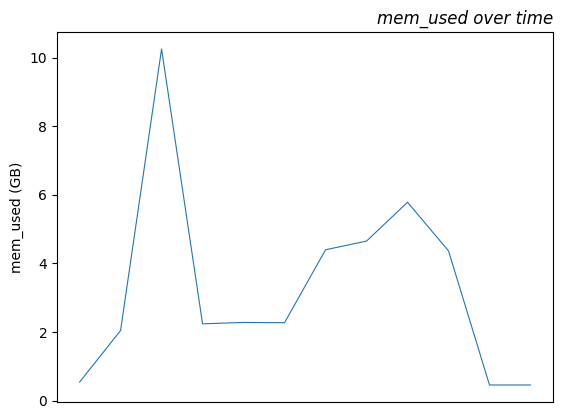

In [4]:
mw.save_metric_plot(file_path=f"/tmp/{instance_id}_plot.png", query_kwargs=query_kwargs)
mw.save_metric_csv(file_path=f"/tmp/{instance_id}_metric.csv", query_kwargs=query_kwargs)
mw.save_metric_json(file_path=f"/tmp/{instance_id}_metric.json", query_kwargs=query_kwargs)
mw.save_response_json(file_path=f"/tmp/{instance_id}_response.json", query_kwargs=query_kwargs)

### Manual EC2 querying

For users that require more control over the EC2 instance query settings, the `query_ec2_metrics` method can be used to manually query the EC2 instance. For instance it allows to fine tune the query period settings.

In [5]:
FINE_TUNED_SETTINGS = {
    "days": 5,
    "hours": 0,
    "minutes": 0,
    "stat": "Maximum",
    "period": 60,
}
response = mw.query_ec2_metrics(**FINE_TUNED_SETTINGS)

response["ResponseMetadata"]

{'RequestId': '256d262e-488a-42bc-9197-2fcd4df82e98',
 'HTTPStatusCode': 200,
 'HTTPHeaders': {'x-amzn-requestid': '256d262e-488a-42bc-9197-2fcd4df82e98',
  'content-type': 'text/xml',
  'content-length': '1596',
  'date': 'Wed, 19 Jul 2023 18:35:04 GMT'},
 'RetryAttempts': 0}

### `TimedMetric` dataclass

Internally, the package uses `TimedMetric` dataclass to store the metric data. This dataclass is used to store the metric data and provide a convenient interface to access the data. It can be also used to interact with the metric data by the user.

In [6]:
response = mw.query_ec2_metrics(**FINE_TUNED_SETTINGS)
timed_metric = mw.timed_metric_factory(response)[0]
print(timed_metric.__class__)
timed_metric.values[1:10]

<class 'cloudwatcher.metric_handlers.TimedMetric'>


[485814272.0,
 4685066240.0,
 6207594496.0,
 4992217088.0,
 4720185344.0,
 2435854336.0,
 2444738560.0,
 2400739328.0,
 11007488000.0]

## `LogWatcher`: convenient interface to AWS CloudWatch logs

`LogWatcher` can be used to interact with AWS CloudWatch logs.

### `LogWatcher` initialization

As described in the Login credentials section, the AWS credentials can be sourced from environment variables: `AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY`, `AWS_SESSION_TOKEN`.
Alternatively, you can pass the values as arguments to the `LogWatcher` constructor.

In [7]:
from cloudwatcher.logwatcher import LogWatcher
from dotenv import load_dotenv
import os

load_dotenv()

lw = LogWatcher(
    log_group_name=os.environ.get("LOG_GROUP_NAME"),
    log_stream_name=os.environ.get("LOG_STREAM_NAME"),
)

Importantly, you can also provide the start token for the log, which will be used to determine the starting point of the log query.

### Log streaming

`LogWatcher` provides a convenient interface to stream the logs from AWS CloudWatch. There are 2 relevant parameters in `stream_cloudwatch_logs` method:

- `events_limit` - the maximum number of events to be returned. If the value is set to `None`, 1000 events are returned
- `max_retry_attempts` - the maximum number of retry attempts to be made if the query results with an empty log

The `stream_cloudwatch_logs` method returns a generator that yields the log events, for example in a `for` loop. In the example below , we use `next` to get the first event from the generator.

In [8]:
streamer = lw.stream_cloudwatch_logs(events_limit=2, max_retry_attempts=2)
next(streamer)

LogEventsList(events=[LogEvent(message='[2023-07-19 12:34:48,735 - INFO] Nephele, developed by BCBB/OCICB/NIAID/NIH version: 2.27.1, tag: Nephele_2023_July_19, commit: dce18e5', timestamp=datetime.datetime(2023, 7, 19, 12, 34, 48, 833000)), LogEvent(message='[2023-07-19 12:34:48,736 - INFO] Python version: 3.9.2', timestamp=datetime.datetime(2023, 7, 19, 12, 34, 48, 833000))], next_forward_token='f/37683453325894048129959718411585392236426944928309968897/s', next_backward_token='b/37683453325894048129959718411585392236426944928309968896/s')

The log events are returned as a custom `LogEventsList` object, which conists of a list of `LogEvents` and tokens. The next token (`LogEventsList.next_forward_token`) can be used to get the next batch of log events. The token can be provided to the `LogWatcher` constructor to start streaming from the last event.

### Retrieving all logs

Alternatively, the `return_formatted_logs` method can be used to retrieve all the logs. This method returns a `Tuple[str,str]`, where the first element is the formatted log and the second element is the next token. 

In [9]:
formatted_logs, token = lw.return_formatted_logs()

print(formatted_logs)


[19-07-2023 12:34:48 UTC] Nephele, developed by BCBB/OCICB/NIAID/NIH version: 2.27.1, tag: Nephele_2023_July_19, commit: dce18e5
[19-07-2023 12:34:48 UTC] Python version: 3.9.2
[19-07-2023 12:34:48 UTC] Current time: 2023-07-19 12:34
[19-07-2023 12:34:49 UTC] Pipeline name: DADA2
[19-07-2023 12:34:49 UTC] Job Description:
[19-07-2023 12:34:49 UTC] Job parameters
[19-07-2023 12:34:49 UTC] job_id: b73de8bfdd22
[19-07-2023 12:34:49 UTC] inputs_dir: None
[19-07-2023 12:34:49 UTC] outputs_dir: None
[19-07-2023 12:34:49 UTC] map_file: <_io.TextIOWrapper name='/nephele_data/inputs/N2_16S_example_mapping_file_3_corrected.txt' mode='r' encoding='UTF-8'>
[19-07-2023 12:34:49 UTC] data_type: PE
[19-07-2023 12:34:49 UTC] wurlitzer_stdout: file
[19-07-2023 12:34:49 UTC] wurlitzer_stderr: file
[19-07-2023 12:34:49 UTC] ion_torrent: False
[19-07-2023 12:34:49 UTC] trimleft_fwd: 0
[19-07-2023 12:34:49 UTC] trimleft_rev: 0
[19-07-2023 12:34:49 UTC] maxee: 5
[19-07-2023 12:34:49 UTC] trunclen_fwd: 0
[19